# Visualization for DV and DC

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time

In [33]:
%matplotlib inline

In [34]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [35]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [36]:
import warnings

In [37]:
from sklearn.decomposition import PCA

In [38]:
from sklearn.preprocessing import StandardScaler

In [39]:
import sys
sys.path.append('/data/home/Github/scrna-parameter-estimation/scmemo')
import estimator, simulate, scmemo, bootstrap, util, hypothesis_test

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [40]:
fig_path = '/data/home/Github/scrna-parameter-estimation/figures/fig5/'
data_path = '/data/parameter_estimation/'

### Load the data

In [41]:
cts = ['CD4 T cells',  'CD14+ Monocytes', 'FCGR3A+ Monocytes', 'NK cells','CD8 T cells', 'B cells']
label_converter = dict(zip(cts, ['Th', 'cM', 'ncM', 'NK', 'Tc', 'B']))

In [42]:
def simplify_name(name):
    return name.split('.')[0]

In [43]:
adata = sc.read(data_path + 'interferon_filtered.h5ad')
adata = adata[(adata.obs.multiplets == 'singlet') & (adata.obs.cell != 'nan'), :].copy()
adata.X = adata.X.astype(np.int64)

In [55]:
norm_adata = adata.copy()
sc.pp.normalize_total(norm_adata, target_sum=1e4)
# sc.pp.log1p(norm_adata)

In [45]:
adata.obs.cell.value_counts()

CD4 T cells          10342
CD14+ Monocytes      5341 
B cells              2564 
CD8 T cells          2035 
NK cells             1988 
FCGR3A+ Monocytes    1586 
Dendritic cells      432  
Megakaryocytes       207  
Name: cell, dtype: int64

In [46]:
adata.obs['cell_type'] = (adata.obs['cell'].astype(str) + ' - ' + adata.obs['stim'].astype(str)).astype('category')

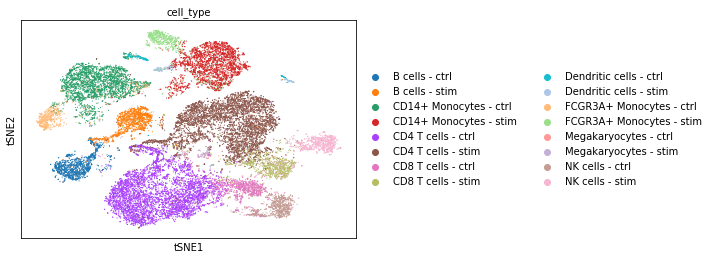

In [47]:
sc.pl.tsne(adata, color='cell_type')

In [48]:
# plt.figure(figsize=(5, 3))
# sns.boxplot(x='n_counts', y='cell_type', data=adata.obs)
# plt.title('Total UMI counts by cell type')
# plt.savefig('celltype_numi.pdf')
# plt.savefig('celltype_numi.png')

In [49]:
print('Number of genes kept:', adata.shape[1])

Number of genes kept: 35635


In [50]:
with open(data_path + 'all_highcount_tfs.pkl', 'rb') as f:
	tfs = pkl.load(f)

### Functions

In [29]:
def plot_gene_product(adata, gene_1, gene_2):
    adata.obs['temp'] = np.log(adata_ct[:, gene_1].X.toarray()*adata_ct[:, gene_2].X.toarray() + 1)
    sc.pl.tsne(adata, color='temp')
    
def get_ct_ind_corr(adata, gene_1, gene_2):
    
    adata_temp = adata.copy()
    scmemo.create_groups(adata_temp, label_columns=['cell', 'stim','ind'], inplace=True)
    scmemo.compute_1d_moments(
        adata_temp, inplace=True, filter_genes=False, 
        residual_var=True, use_n_umi=False, filter_mean_thresh=0.125, 
        min_perc_group=0.99)
    scmemo.compute_2d_moments(adata_temp, [gene_1], [gene_2])
    df_list = []
    for group in adata_temp.uns['scmemo']['groups']:
        _, ct, stim, ind = group.split('^')
        if ct not in cts:
            continue
        df_list.append((label_converter[ct], stim,ind,adata_temp.uns['scmemo']['2d_moments'][group]['corr'][0][0]))
    df = pd.DataFrame(df_list, columns=['ct', 'stim','ind', 'corr']).sort_values('ct')
    df['corr'] = df['corr'].apply(lambda x: np.nan if abs(x) > 1 else x)
    
    return df

In [99]:
def plot_microscopy(X, c1, c2, s=5, q=.95, min_val=0.1):
    
    N = X.shape[0]
    
    plt.figure(figsize=(10, 2.5))
    
    c1 = np.clip(c1, a_min=0, a_max=np.quantile(c1, q))
    c2 = np.clip(c2, a_min=0, a_max=np.quantile(c2, q))

    c1 = (c1 - c1.min())/(c1.max()-c1.min())
    c2 = (c2 - c2.min())/(c2.max()-c2.min())
    
    c1 = np.clip(c1, a_min=min_val, a_max=1)
    c2 = np.clip(c2, a_min=min_val, a_max=1)
    
    plt.subplot(1, 3, 1); plt.scatter(X[:, 0], X[:, 1], c=np.vstack([c1, np.zeros(N), np.zeros(N)]).T, s=s)
    plt.gca().set_facecolor((0, 0, 0))
    plt.xticks([]); plt.yticks([])
    plt.subplot(1, 3, 2); plt.scatter(X[:, 0], X[:, 1], c=np.vstack([np.zeros(N), c2, np.zeros(N)]).T, s=s)
    plt.gca().set_facecolor((0, 0, 0))
    plt.xticks([]); plt.yticks([])
    plt.subplot(1, 3, 3); plt.scatter(X[:, 0], X[:, 1], c=np.vstack([c1, c2, np.zeros(N)]).T, s=s)
    plt.gca().set_facecolor((0, 0, 0))
    plt.xticks([]); plt.yticks([])
    
    plt.figure()
    sns.distplot(c1)
    sns.distplot(c2)
    

### Visualization


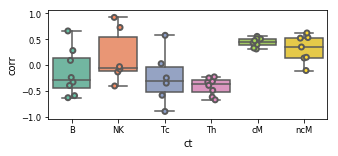

In [52]:
plt.figure(figsize=(5, 2))
gene_1, gene_2 = 'EEF1D', 'BTG1'
plot_df = get_ct_ind_corr(adata[adata.obs.stim == 'stim'], gene_1, gene_2)#.query('ct in ["B", "NK", "Th", "cM"]')
sns.boxplot(x='ct', y='corr',
    data=plot_df, 
    palette='Set2')
sns.stripplot(x='ct', y='corr',
    data=plot_df, 
    palette='Set2', linewidth=2)

In [101]:
norm_adata = adata.copy()
sc.pp.normalize_total(norm_adata, target_sum=1e4)
sc.pp.log1p(norm_adata)

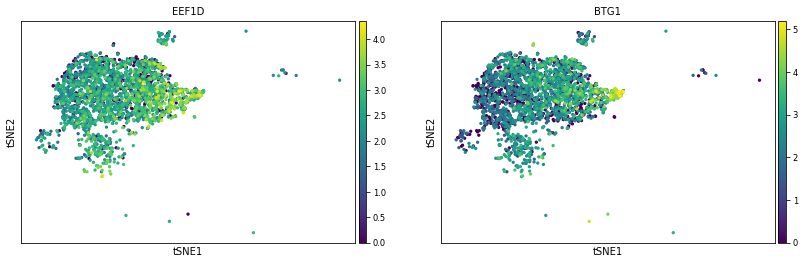

In [102]:
sc.pl.tsne(norm_adata[(norm_adata.obs.stim == 'ctrl') & (norm_adata.obs.cell == 'CD14+ Monocytes')], color=[gene_1, gene_2])


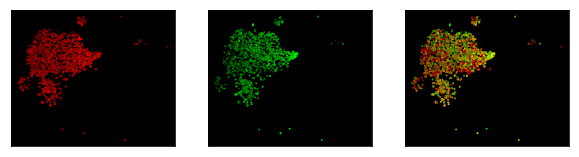

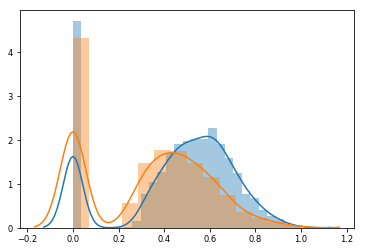

In [104]:
plot_ct = 'CD14+ Monocytes'
plot_microscopy(
    X=norm_adata[(norm_adata.obs.stim == 'ctrl') & (norm_adata.obs.cell == plot_ct)].obsm['X_tsne'],
    c1=norm_adata[(norm_adata.obs.stim == 'ctrl') & (norm_adata.obs.cell == plot_ct), gene_1].X.todense().A1,
    c2=norm_adata[(norm_adata.obs.stim == 'ctrl') & (norm_adata.obs.cell == plot_ct), gene_2].X.todense().A1,
    s=1,
    q=1, 
    min_val=0.0)